In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
def detect_cycles_or_spikes(signal, time_vector, distance=None, kind="lfp", epsilon=0.01):
    """
    Detect peaks or spike times based on signal type.
    
    Parameters:
    - signal: 1D numpy array
    - time_vector: corresponding 1D time vector
    - distance: window size for local peak detection (optional)
    - kind: "lfp" or "spike"
    - epsilon: prominence threshold for LFP peak detection

    Returns:
    - peaks: list of peak values
    - tm: list of peak times
    - peak_indices: list of indices in signal
    """
    if distance is None:
        distance = 150 if kind == "lfp" else 50

    peaks = []
    peak_indices = []

    if kind == "lfp":
        # --- LFP-style peak/trough detection ---
        i = 0
        n = len(signal)
        searching_peak = True
        current_peak = signal[i]

        while i < n - distance:
            segment = signal[i:i+distance]
            if searching_peak:
                if np.max(segment) > current_peak + epsilon:
                    j = np.argmax(segment)
                    current_peak = segment[j]
                    i += j
                else:
                    peaks.append(current_peak)
                    peak_indices.append(i)
                    current_peak = signal[i]
                    searching_peak = False
                    i += 1
            else:
                if np.min(segment) < current_peak - epsilon:
                    j = np.argmin(segment)
                    current_peak = segment[j]
                    i += j
                else:
                    current_peak = signal[i]
                    searching_peak = True
                    i += 1

        # Fix: remove spurious initial peak
        if len(peak_indices) > 0 and peak_indices[0] == 0:
            peak_indices = peak_indices[1:]
            peaks = peaks[1:]

    elif kind == "spike":
        # --- Spike threshold-based detection (>3 followed by <0) ---
        if np.any(signal > 3):
            for j in range(len(signal) - 1):
                if signal[j] > 3 and signal[j + 1] < 0:
                    peak_indices.append(j)
                    peaks.append(signal[j])
        else:
            # No spike detected => skip completely
            return np.array([]), np.array([]), np.array([])

    else:
        raise ValueError("Invalid kind. Must be 'lfp' or 'spike'.")

    tm = time_vector[peak_indices]
    return np.array(peaks), np.array(tm), np.array(peak_indices)

In [3]:
# Step 2
def compute_mvl_per_population(df, tm, pop_prefix, num_neurons=400, distance=None, epsilon=0.01):
    """"
    Computes MVL (mean vector length) for a population of neurons using phase-locking 
    to the reference signal cycles (tm).
    
    Parameters:
    - df: DataFrame containing time and voltage signals
    - tm: Reference LFP cycle times (e.g., from se)
    - pop_prefix: 'qe', 'qi', or 'qs'
    - num_neurons: Number of neurons in the population (default: 400)
    - distance: Window size for detecting peaks (default: 150)
    - epsilon: Prominence threshold for peaks (default: 0.01)

    Returns:
    - Dictionary with individual MVLs, their mean, and number of neurons used
    """
    mvls_phsft = []
    time_vector = df["t"].values

    for i in range(num_neurons):
        col = f"{pop_prefix}{i}"
        if col not in df.columns:
            continue

        signal = df[col].values
        _, t_peaks, _ = detect_cycles_or_spikes(signal, time_vector, kind="spike", distance=distance, epsilon=epsilon)

        # Compute spike phases relative to LFP cycle timings
        spike_phases = []
        for x in t_peaks:
            for k in range(len(tm) - 1):
                lo = tm[k]
                hi = tm[k + 1]
                if lo < x < hi:
                    period = hi - lo
                    phase = 360 * (x - lo) / period
                    spike_phases.append(phase)
                    break

        if len(spike_phases) == 0:
            continue

        complex_phase = np.exp(1j * np.radians(spike_phases))
        vec = np.mean(complex_phase)
        mvl = np.abs(vec)
        mean_angle = np.angle(vec, deg=True)  # degrees from -180 to 180

        mvls_phsft.append((mvl, mean_angle))

    mvls_phsft = np.array(mvls_phsft)
    mvl_vals = mvls_phsft[:, 0]
    phase_shifts = mvls_phsft[:, 1]

    return {
        'individual_mvls': mvl_vals,
        'individual_phases': phase_shifts,
        'mean_mvl': np.mean(mvl_vals) if len(mvl_vals) > 0 else None,
        'mean_phase': np.mean(phase_shifts) if len(phase_shifts) > 0 else None,
        'n_neurons_used': len(mvl_vals)
    }

In [4]:
# Step 3
def run_mvl_pipeline(df, pop_prefixes=["qe", "qi", "qs"], distance=150, epsilon=0.01):
    """
    Full pipeline to compute MVLs for each neuron population.
    
    Steps:
    1. Extract LFP cycle times from 'se'
    2. For each population (qe, qi, qs), detect spike peaks and compute MVL

    Parameters:
    - df: Pandas DataFrame with 't', 'se', 'qe0'..'qs399' columns
    - pop_prefixes: List of population prefixes to include
    - distance: Window size for peak detection
    - epsilon: Small threshold for peak detection

    Returns:
    - mvl_results: Dictionary containing MVL stats for each population
    - tm: LFP cycle peak times
    """
    # Step 1: Detect LFP peak times from "se"
    se_signal = df["se"].values
    time_vector = df["t"].values
    _, tm, _ = detect_cycles_or_spikes(se_signal, time_vector, kind="lfp", distance=distance, epsilon=epsilon)

    # Step 2: Compute MVL for each population
    mvl_results = {}
    for pop in pop_prefixes:
        result = compute_mvl_per_population(df, tm, pop, num_neurons=400, distance=distance, epsilon=epsilon)
        mvl_results[pop] = result
        print(f"{pop}: Average MVL = {result['mean_mvl']:.4f} and Mean Phase shift = {result['mean_phase']:.4f} across {result['n_neurons_used']} neurons")

    return mvl_results, tm


In [5]:
# Load your dataset (adjust path)
file_path = "lfp_small.dat"
df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


#Assign columns (ignoring the last 2 extras if present)
columns = ["t", "se"] + \
          [f"qe{i}" for i in range(400)] + \
          ["si"]+\
          [f"qi{i}" for i in range(400)] + \
          ["ss"]+\
          [f"qs{i}" for i in range(400)] + \
          ["tt"]

df_lfp.columns = columns

/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_75377/2124942144.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


In [6]:
df_lfp.drop(columns="tt", inplace=True)

In [7]:
mvl_results_small, tm_small = run_mvl_pipeline(df_lfp)

qe: Average MVL = 0.3644 and Mean Phase shift = -8.9809 across 396 neurons
qi: Average MVL = 0.8860 and Mean Phase shift = 70.3736 across 359 neurons
qs: Average MVL = 0.8841 and Mean Phase shift = 72.9912 across 201 neurons


In [8]:
def count_peaks_custom(signal, time_vector, kind="lfp", distance=150, epsilon=0.01):
    _, _, peak_indices = detect_cycles_or_spikes(signal, time_vector, kind=kind, distance=distance, epsilon=epsilon)
    return len(peak_indices)

In [9]:
peak_counts = {
    "se": count_peaks_custom(df_lfp["se"].values, df_lfp["t"].values, kind="lfp")
}

for pop in ["qe", "qi", "qs"]:
    for i in range(400):
        col = f"{pop}{i}"
        if col in df_lfp.columns:
            count = count_peaks_custom(df_lfp[col].values, df_lfp["t"].values, kind="spike")
            peak_counts[col] = count

In [10]:
# Convert dictionary to DataFrame
df_peak_counts = pd.DataFrame(list(peak_counts.items()), columns=["Neuron", "NumPeaks"])

# Display first few rows
display(df_peak_counts.head())

# Summary statistics grouped by population prefix
summary_stats = df_peak_counts.groupby(df_peak_counts["Neuron"].str[:2])["NumPeaks"].describe()
print(summary_stats)

,Neuron,NumPeaks
0,se,8
1,qe0,10
2,qe1,3
3,qe2,10
4,qe3,9


        count    mean       std  min  25%   50%   75%   max
Neuron                                                     
qe      400.0  9.5725  1.669344  0.0  9.0  10.0  10.0  19.0
qi      400.0  8.0650  5.835745  0.0  8.0   8.0   8.0  67.0
qs      400.0  3.2475  5.767965  0.0  0.0   1.0   6.0  60.0
se        1.0  8.0000       NaN  8.0  8.0   8.0   8.0   8.0


In [11]:
# Filter for qe neurons with exactly 19 peaks
qs_60_peaks = df_peak_counts[(df_peak_counts["Neuron"].str.startswith("qs")) & 
                             (df_peak_counts["NumPeaks"] == 60)]

# Display results
print(qs_60_peaks)


     Neuron  NumPeaks
1043  qs242        60


In [12]:
p_value, t_peaks, p_idx = detect_cycles_or_spikes(df_lfp.qi75.values, df_lfp.t.values, kind='spike') 
print(t_peaks, p_value)

[] []


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phase_locking_histograms(df, tm, pop_prefixes=["qe", "qi", "qs"], num_neurons=400):
    time_vector = df["t"].values

    for pop in pop_prefixes:
        all_phases = []
        for i in range(num_neurons):
            col = f"{pop}{i}"
            if col not in df.columns:
                continue
            signal = df[col].values
            _, t_peaks, _ = detect_cycles_or_spikes(signal, time_vector, kind="spike")

            spike_phases = []
            for x in t_peaks:
                for k in range(len(tm) - 1):
                    lo = tm[k]
                    hi = tm[k + 1]
                    if lo < x < hi:
                        period = hi - lo
                        phase = 360 * (x - lo) / period
                        phase = (phase + 180) % 360 - 180  # Convert to [-180, 180)
                        spike_phases.append(phase)
                        break

            all_phases.extend(spike_phases)

        if all_phases:
            plt.figure(figsize=(6, 4))
            plt.hist(all_phases, bins=36, range=(-180, 180), color='skyblue', edgecolor='black')
            plt.title(f"Phase Locking Histogram for {pop.upper()}")
            plt.xlabel("Phase (degrees)")
            plt.ylabel("Spike Count")
            plt.xticks(np.arange(-180, 181, 60))
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"[{pop.upper()}] No valid spikes detected — skipping histogram.")


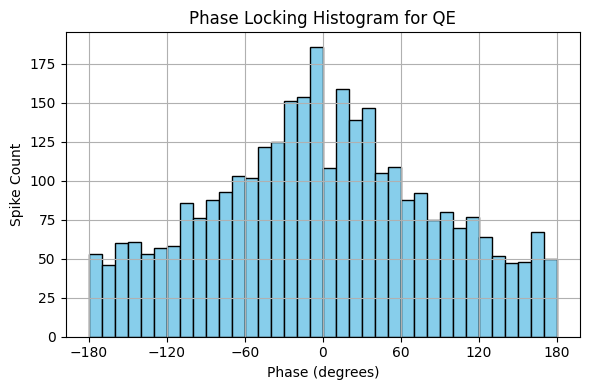

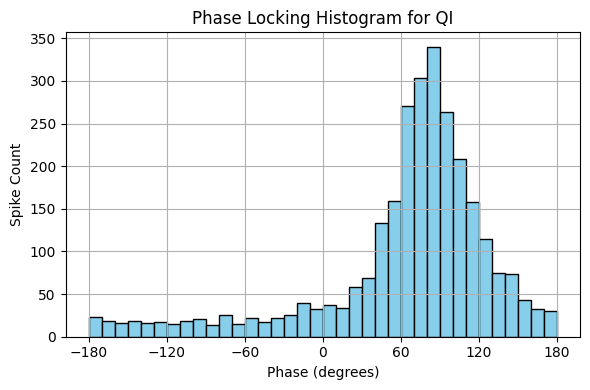

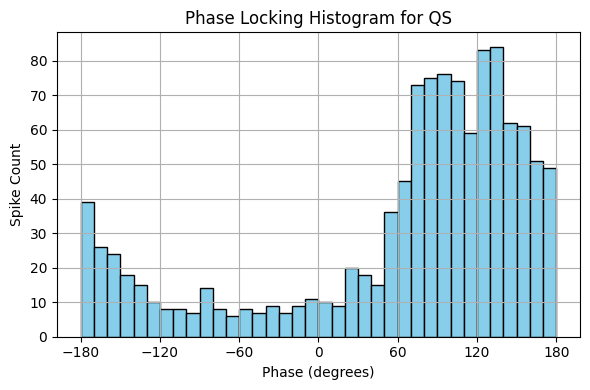

In [14]:
plot_phase_locking_histograms(df_lfp, tm_small)

In [20]:
# Compute total duration
T_total = df_lfp["t"].values[-1] - df_lfp["t"].values[0]  # ≈ 500

# Mean firing rate per population
mean_firing_rates = {}
total_spikes_count={}
for pop in ["qe", "qi", "qs"]:
    # Total spike count for the population
    total_spikes = df_peak_counts[df_peak_counts["Neuron"].str.startswith(pop)]["NumPeaks"].sum()
    mean_fr = total_spikes / (400 * T_total)
    mean_firing_rates[pop] = mean_fr
    total_spikes_count[pop] = total_spikes

# Display results
print("Mean Firing Rate (Hz):")
for pop, fr in mean_firing_rates.items():
    print(f"  {pop.upper()}: {fr:.6f} Hz")
for pop, fr in total_spikes_count.items():
    print(f"  {pop.upper()}: {fr}" )

Mean Firing Rate (Hz):
  QE: 0.019145 Hz
  QI: 0.016130 Hz
  QS: 0.006495 Hz
  QE: 3829
  QI: 3226
  QS: 1299


In [16]:
df_peak_counts[df_peak_counts["Neuron"].str.startswith("qs")]["NumPeaks"].sum()

1299